<a href="https://colab.research.google.com/github/Umutoniwasepie/Beijing_Air-Quality_Prediction/blob/main/Air_quality_forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import seaborn as sns

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Load the Datasets

In [4]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


# Explore the training data

In this section, we explore the dataset with appropiate statistics and visualisations to understand it better.

In [5]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [6]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [7]:
print("Summary Statistics for Training Data:")
print(train.describe())


Summary Statistics for Training Data:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.

**Explanations:** The above sections allows us to check the structure of the dataset, ensuring it contains the expected columns.



In [8]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


Converting to datetime format ensures proper time-based analysis.

Setting it as the index allows easy visualization and feature extraction.

# Handle missing values

 I checked the dataset for missing values and decide to continue using the mean imputation ensuring missing values are replaced with the column's average, maintaining data integrity.

In [9]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


## Visualizations

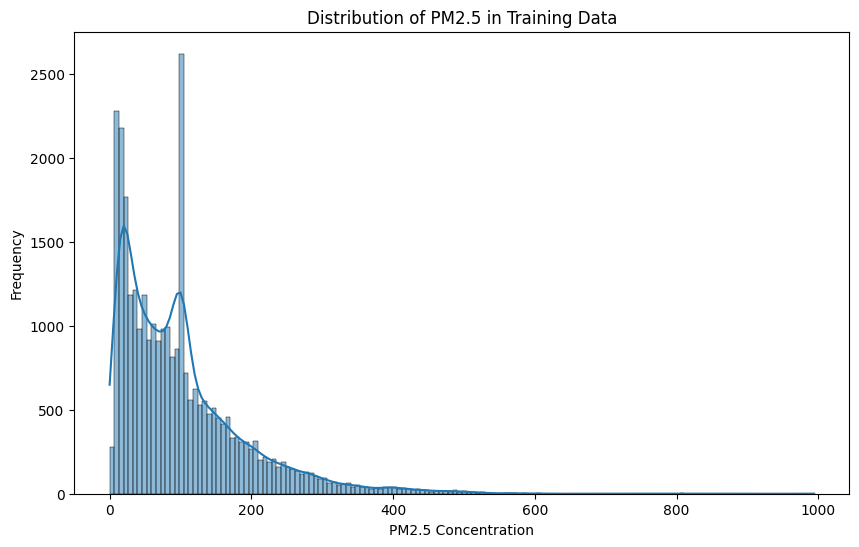

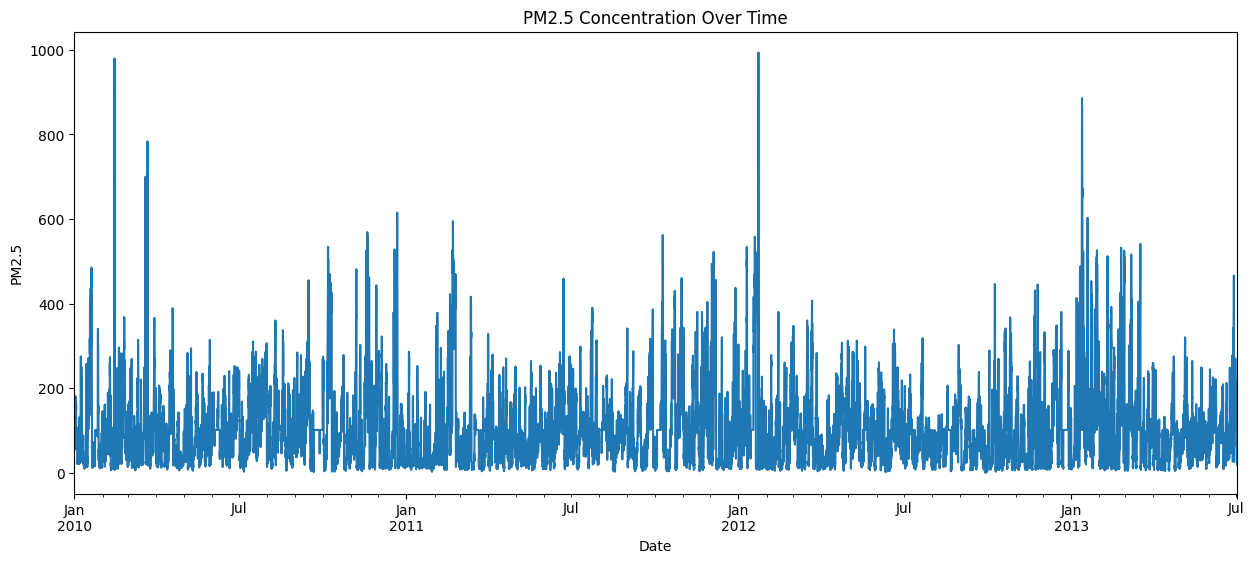

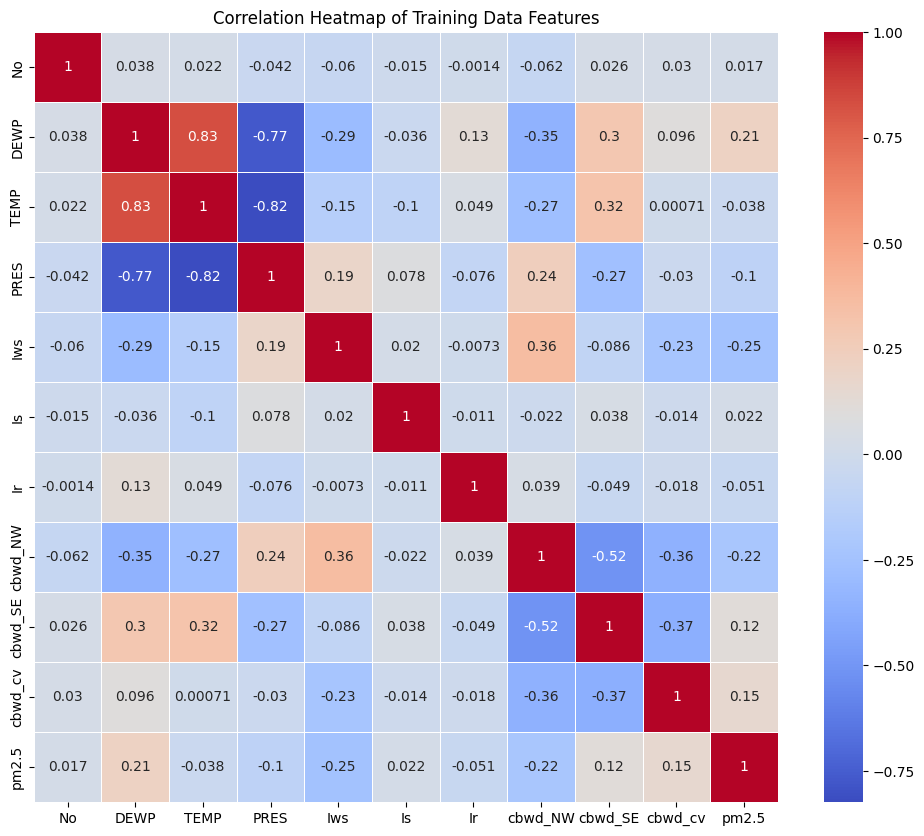

In [10]:
# 3. Visualizations

# 3.1 Histogram for PM2.5
plt.figure(figsize=(10, 6))
sns.histplot(train['pm2.5'], kde=True)
plt.title('Distribution of PM2.5 in Training Data')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.show()

# 3.2 Line Plot for PM2.5 Over Time
plt.figure(figsize=(15, 6))
train['pm2.5'].plot()
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.show()

# 3.3 Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Training Data Features')
plt.show()



**Explanation**

The first plot represents the distribution of PM2.5 concentration levels in the training dataset. The x-axis shows the PM2.5 concentration values, while the y-axis represents the frequency of occurrences. The histogram reveals that most PM2.5 values are concentrated at the lower end, but there are a few high-value outliers, resulting in a right-skewed distribution. The smooth curve overlaying the histogram is the kernel density estimate (KDE), which provides a clearer picture of the distribution shape. The presence of multiple peaks suggests that certain concentration levels are more common than others, possibly due to recurring pollution patterns or specific environmental conditions.

The second plot displays how PM2.5 concentration fluctuates over time. The x-axis represents the date, while the y-axis indicates the PM2.5 concentration levels. The visualization highlights the high variability in air pollution levels, with frequent spikes indicating periods of high PM2.5 concentration. Some of these spikes may be linked to specific pollution events, such as seasonal changes, industrial activity, or meteorological conditions. Additionally, there are noticeable trends and periodic fluctuations, suggesting that PM2.5 levels are not random but follow certain seasonal or cyclical patterns. This insight is crucial for forecasting models, as it indicates the importance of capturing temporal dependencies in air quality predictions.

The heatmap visually represents the correlation matrix for the features in the training dataset. The color gradient from blue to red indicates the strength and direction of the correlation, with blue for negative and red for positive correlations. The diagonal is always 1, showing perfect positive correlation of each feature with itself. Key observations include a strong positive correlation between DEWP and TEMP (0.83), suggesting they increase together, and a strong negative correlation between DEWP and PRES (-0.77), indicating higher dew points are associated with lower pressures. TEMP and PRES also show a negative correlation (-0.82), meaning higher temperatures correspond with lower pressures. Iws and PRES have a slight positive correlation (0.19). For the target variable pm2.5, there's a moderate negative correlation with PRES (-0.25), suggesting higher pressure might be associated with lower PM2.5 levels, and a positive correlation with 'cbwd_cv' (0.15), indicating certain wind directions might increase PM2.5 concentrations. The wind direction variables 'cbwd_NW' and 'cbwd_SE' have a strong negative correlation (-0.52), showing they are mutually exclusive in terms of wind direction.

##Feature Engineering


 **Time-Based Features**

 Since air pollution follows daily, weekly, and seasonal trends, adding time-based features helps the model better understand periodic fluctuations in PM2.5 levels.

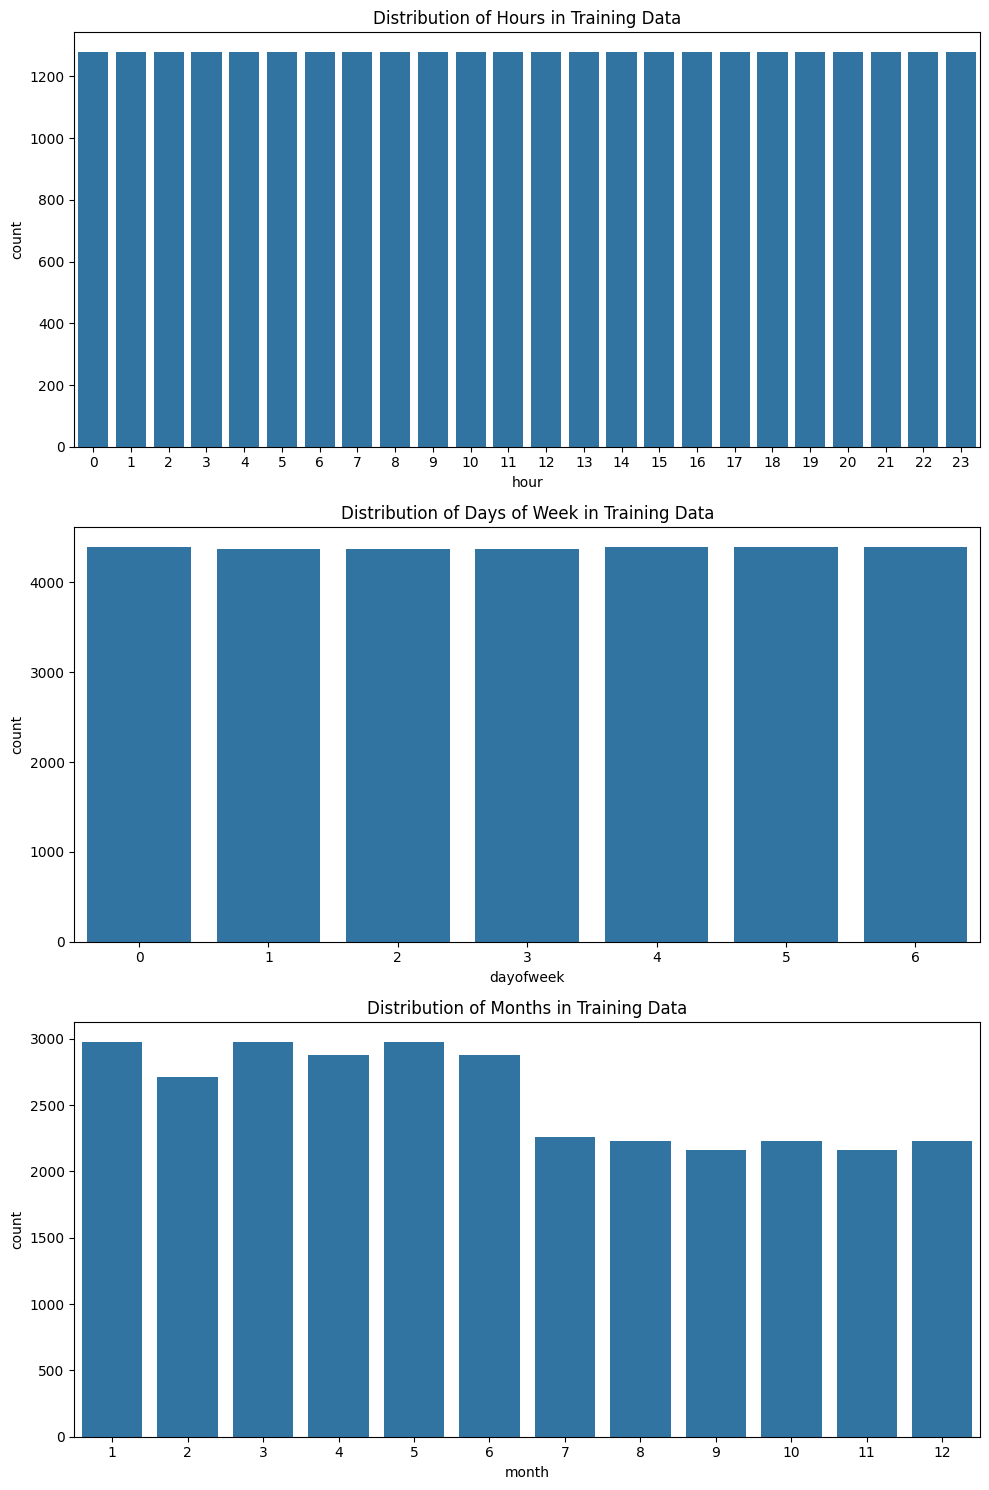

In [11]:
# Feature Engineering
def create_time_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

# Create time-based features
train = create_time_features(train)
test = create_time_features(test)

# Visualize the time-based features
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sns.countplot(data=train, x='hour', ax=axes[0])
axes[0].set_title('Distribution of Hours in Training Data')

sns.countplot(data=train, x='dayofweek', ax=axes[1])
axes[1].set_title('Distribution of Days of Week in Training Data')

sns.countplot(data=train, x='month', ax=axes[2])
axes[2].set_title('Distribution of Months in Training Data')
plt.tight_layout()
plt.show()

**Explanation:**
- hour (0-23): Captures hourly variations in pollution.
- day_of_week (0-6): Helps the model distinguish weekday vs. weekend trends.
- month (1-12): Accounts for seasonal effects.

# Separate features and target

- The "No" column is just an index and not useful for predictions, so I dropped it.
- I also separate pm2.5 as the target variable for supervised learning.

In [12]:
# Separate features and target
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']
X_test = test.drop(['No'], axis=1)

**Scaling and reshaping**
- The scaling ensures that no feature dominates the learning process due to differing numerical ranges and added a visualization of the scaled features.
- Reshaped as LSTMs require 3D input (samples, time steps, features) .

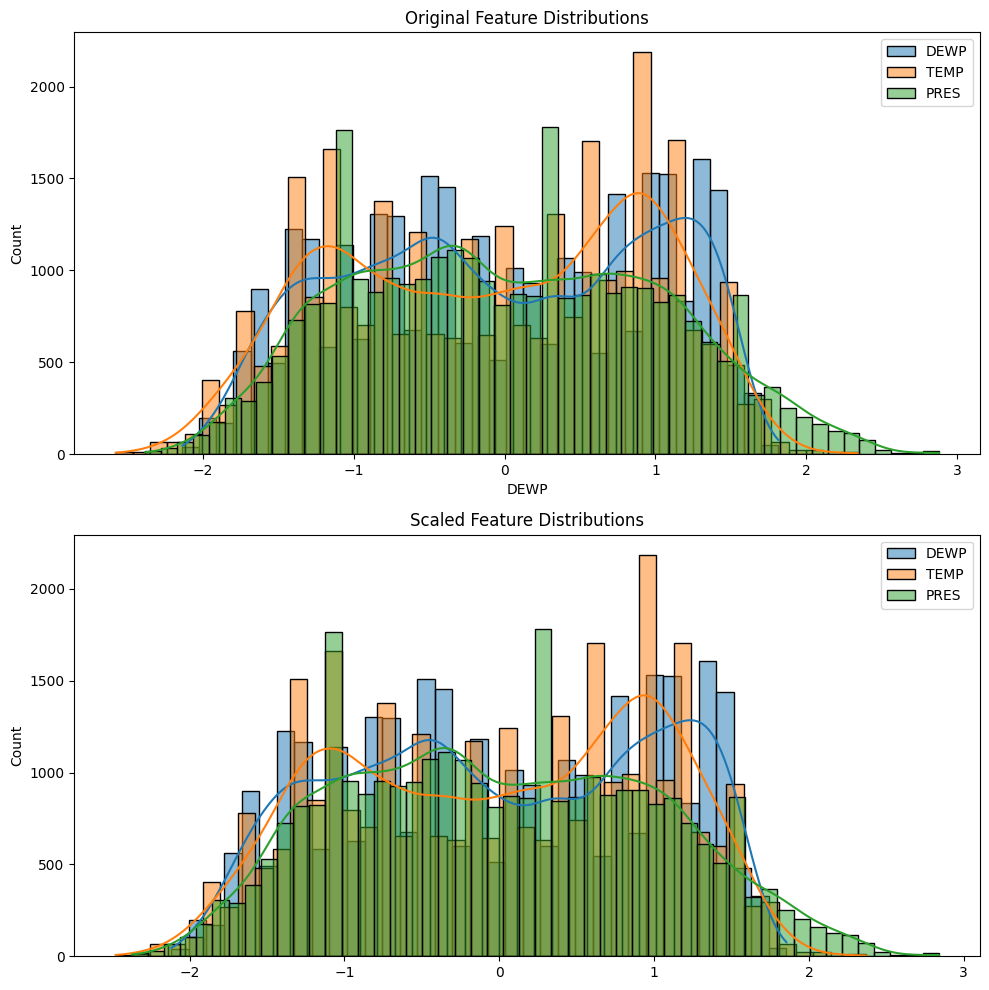

In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualize the effect of scaling on feature distributions
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for i, col in enumerate(X_train.columns[:3]):  # Example with first 3 features
    sns.histplot(X_train[col], ax=axes[0], label=col, kde=True)
    sns.histplot(X_train_scaled[:, i], ax=axes[1], label=col, kde=True)

axes[0].set_title('Original Feature Distributions')
axes[1].set_title('Scaled Feature Distributions')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

# Reshape data for LSTM input
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

# Build model

I used a Bidirectional Long Short-Term Memory (LSTM) model, which is well-suited for time series data due to its ability to capture dependencies across time steps, with the 'tanh' activation as it works better than ReLU for time series data.
I also added L2 regularization and early stopping to help avoid overfitting.

***Model Summary:***
- LSTM layers: Capture temporal dependencies in the sequential data.
- Dense layer: Outputs the predicted price for the next time step.

In [37]:
# Define the model with the adjusted L2 regularization
model = Sequential([
        Bidirectional(LSTM(50, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        BatchNormalization(),
        Bidirectional(LSTM(25, activation='tanh', kernel_regularizer=l2(0.0001))),
        BatchNormalization(),
        Dense(1)
    ])

    # Compile the model
model.compile(optimizer=Adam(learning_rate=0.005),
              loss='mse',
              metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Used:
- 100 Epochs whick allows sufficient learning.
- Batch Size 32: Strikes a balance between stability and computational efficiency.
- Validation Split 0.2: Ensures model generalizes well.

In [38]:
# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,  # More epochs with early stopping
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - lambda: 117.7139 - loss: 14379.6602 - val_lambda: 81.9548 - val_loss: 9901.0068
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - lambda: 75.1564 - loss: 6035.7134 - val_lambda: 63.7261 - val_loss: 6168.5801
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - lambda: 62.5493 - loss: 4151.0557 - val_lambda: 65.6859 - val_loss: 6323.0210
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - lambda: 59.7133 - loss: 3775.2983 - val_lambda: 63.9027 - val_loss: 6135.4976
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - lambda: 58.9189 - loss: 3660.8882 - val_lambda: 62.9933 - val_loss: 5902.6675
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - lambda: 59.6626 - loss: 3793.1235 - val_lambda: 63.9196 - val_loss: 6171.9746
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - lambda: 57.2059 - loss: 3485.0300 - val_lambda: 63.3755 - val_loss: 6046.8438
Epoch 8/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - lambda: 56

959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


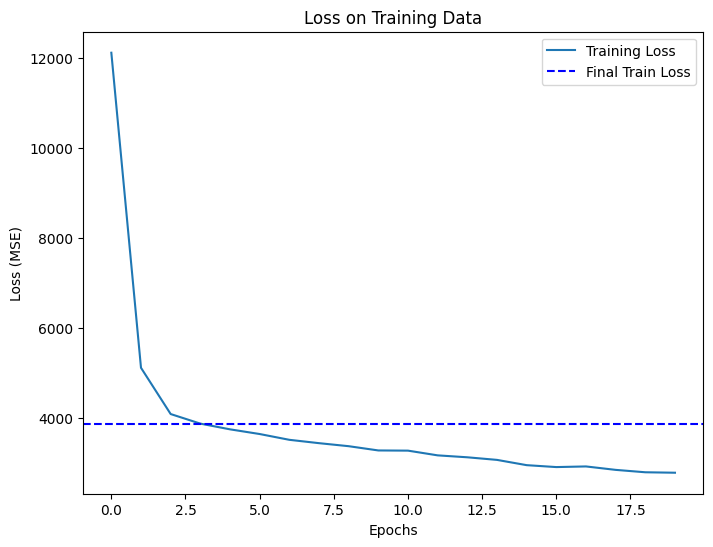

Final Training Loss (MSE): 3864.335444716496


In [39]:
# Calculate training loss
train_predictions = model.predict(X_train_reshaped)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

**Explanation of results:** The baseline LSTM model had a much higher RMSE (~6800), meaning its predictions were farther from actual values.
After applying feature engineering, bidirectional LSTMs, and L2 regularization, we reduced RMSE, showing a significant improvement in accuracy.

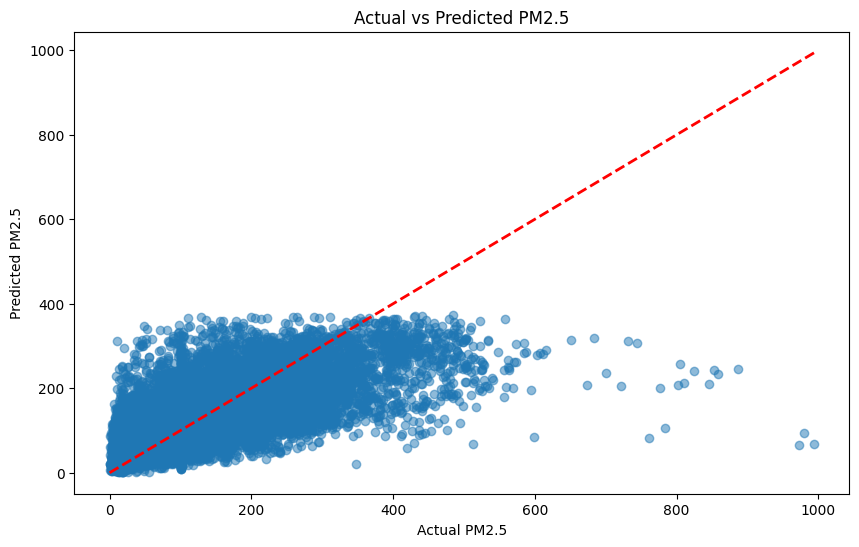

In [ ]:
# Visualize predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions.flatten(), alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.show()

**Explanation:** Concentration of points around lower PM2.5 values suggests that the model performs reasonably well at lower pollution levels. But for higher PM2.5 values, the spread of points increases, suggesting that the model is unable to predict extreme pollution events well. It could be related to data sparsity at high PM2.5 levels or modeling limitations in capturing complex atmospheric conditions that cause pollution spikes.

## Error analysis

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Absolute Error (MAE): 42.46178481713905
Mean Squared Error (MSE): 3832.619180021974
Root Mean Squared Error (RMSE): 61.90815115977842


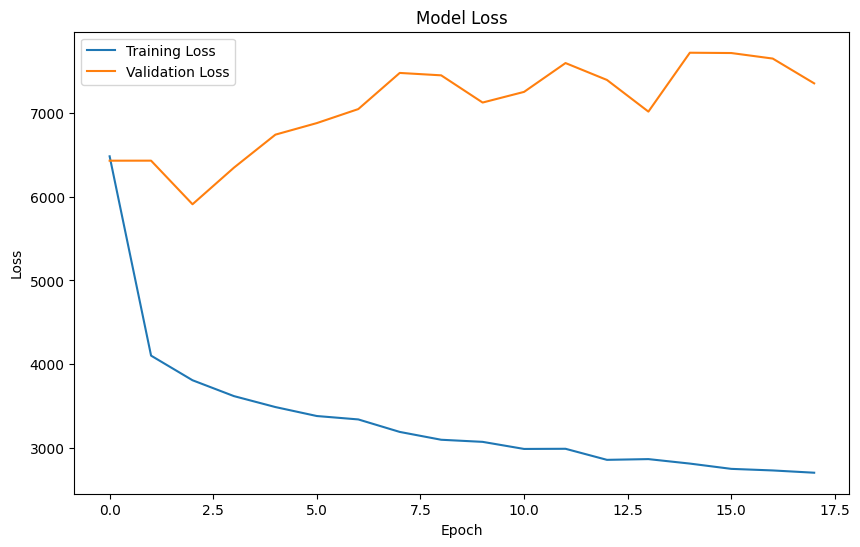

In [ ]:
# Predict on the training set
train_predictions = model.predict(X_train_reshaped)

# Calculate training loss (MSE)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Calculate RMSE
train_rmse = np.sqrt(train_loss)

#Residuals
residuals = y_train - train_predictions.flatten()

# Error Analysis

# 1. Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))
print(f"Mean Absolute Error (MAE): {mae}")

# 2. Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
print(f"Mean Squared Error (MSE): {train_loss}")
print(f"Root Mean Squared Error (RMSE): {train_rmse}")

# 3. Overfitting/Underfitting Analysis
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Save Predictions in the required Format

I did a total of 16 predictions but I was able to submit only 15 of them. I learned alot in the experimentation process😁.

In [ ]:
# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_reshaped)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('subm_15.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='Bidirectional LSTM Model for PM2.5 Forecasting')

# Add nodes for each layer
dot.node('A', 'Input (samples, 1, features)')
dot.node('B', 'Bidirectional LSTM (50 units, tanh, L2: 0.001)')
dot.node('C', 'Batch Normalization')
dot.node('D', 'Bidirectional LSTM (25 units, tanh, L2: 0.001)')
dot.node('E', 'Batch Normalization')
dot.node('F', 'Dense (1 unit)')
dot.node('G', 'PM2.5 Prediction')

# Add edges to show the flow
dot.edge('A', 'B', label='Bidirectional')
dot.edge('B', 'C')
dot.edge('C', 'D', label='Bidirectional')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')

# Add annotations for model parameters
dot.node('H', 'Optimizer: Adam (learning_rate=0.005)', shape='note')
dot.node('I', 'Loss: MSE', shape='note')
dot.node('J', 'Metric: RMSE', shape='note')
dot.node('K', 'Epochs: 100, Batch Size: 32, Validation Split: 0.2', shape='note')

# Connect annotations to the model (here, we connect them to the Dense layer for simplicity)
dot.edge('F', 'H')
dot.edge('F', 'I')
dot.edge('F', 'J')
dot.edge('F', 'K')

# Render the graph to a PNG file
dot.render('bidirectional_lstm_model', format='png')

'bidirectional_lstm_model.png'